# Въведение

## Берлинският въздушен мост

![Окупационни зони в Германия след Втората световна война. Източник: Wikipedia.](https://upload.wikimedia.org/wikipedia/commons/thumb/a/a8/Deutschland_Besatzungszonen_8_Jun_1947_-_22_Apr_1949.svg/800px-Deutschland_Besatzungszonen_8_Jun_1947_-_22_Apr_1949.svg.png){width=800}

::: {#fig-photos layout-ncol=2}

![Генерал Люсиус Клей](https://upload.wikimedia.org/wikipedia/commons/6/6d/GEN_Lucius_D._Clay_portrait_%28cropped%29.jpg){width=500}

![Куртис Лемай](https://upload.wikimedia.org/wikipedia/commons/5/50/Lemay4.jpg){width=500}

Famous Elephants
:::


![Самолети C-47](https://upload.wikimedia.org/wikipedia/commons/b/ba/C-47s_at_Tempelhof_Airport_Berlin_1948.jpg)

![Приземяване на C-54 (Летище Темпелхоф). Източник: Wikipedia.](https://upload.wikimedia.org/wikipedia/commons/d/d8/C-54landingattemplehof.jpg)

![Handley Page Halifax](https://upload.wikimedia.org/wikipedia/commons/9/95/Halifax-mk3.jpg)

## Описание на проблема

За по-просто нека да приемем, че доставките до Берлин се извършват с 
два вида самолети: американски, които могат да поемат до 30 000 кубични фута товар ($\approx 849 m^3$),
и британски самолети с капацитет до 20 000 кубични фута ($\approx 566 m^3$).

- Поради ограничения в инфраструктурата на ден могат да летят най-много 48 самолета (независимо от кой вид).
- За всеки полет на американски самолет има нужда от 16 души персонал, двойно повече от броя нужен за британските самолети. Общо на разположение са 512 души на ден.
- Разходите за гориво и поддръжка на самолетите възлизат на 9000 долара за полет на американски самолет и на 5000 долара за полет на британски самолет. Поради бюджетни ограничения общите разходи не могат да надхвърлят 300 000 долара.

Колко британски и колко американски самолети да използва на ден въздушният мост, така че да достави до Берлин възможно най-голямо количество стоки?


## Математически модел

## Допустимо множество

[desmos.com](https://www.desmos.com)


Допустимото множество се състои от всички точки в полигона (0, 0), (32, 0), (20, 24), (15, 33), (0, 48). Изчислението на пресечните точки (20, 24) и (15, 33).

`polytope` failed to import `cvxopt.glpk`.
will use `scipy.optimize.linprog`


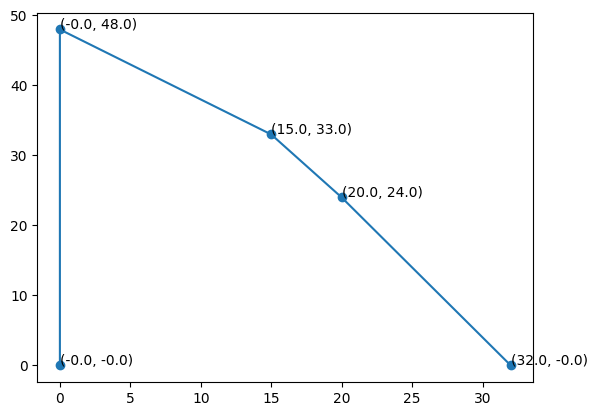

In [1]:
from matplotlib import pyplot as plt
import polytope as pc
import numpy as np

A = np.array([[1, 1], [16, 8], [9, 5], [-1, 0], [0, -1]])
b = np.array([48, 512, 300, 0, 0])

P = pc.Polytope(A, b)
P_extr = pc.extreme(P)

plt.plot(P_extr[:, 0], P_extr[:, 1], '-o')

for i, p in enumerate(P_extr):
    plt.text(p[0], p[1], f"({p[0]:0.1f}, {p[1]:0.1f})")


Оптималната комбинация от американски и британски самолети е 
$(x^*_A = 15, x^*_B = 33)$. Това е възможно най-големият товар, който могат да пренесат самолетите при дадените ограничения. 
Този товар е равен на $30000 $x^*_{A} + 20000 x^*_{B} = 30000 \cdot 15 + 20000 \cdot 33 = 1 110 000$ кубични фута, използвайки 15 американски и 33 британски самолета.

## Проблем с настоящия подход

В момента решихме задачата, като изчислихме върховете на допустимото множество и пресметнахме целевата функция във всеки от тях. Решението на максимизационната задача беше върхът с най-висока стойност на целевата функция.

За съжаление този подход е приложим само за много малки задачи и няма практическа стойност. Причината за това е, че броят на върховете на допустимото множество нараства много бързо с увеличаване на броя на ограниченията и променливите. Горна граница за броя на върховете на допустимото множество е дадена от биномния коефициент:

 $$
 \binom{n}{k} = \frac{n!}{k!(n-k)!}
 $$

 където $n$ е броят на променливите, а $k$ е броят на ограниченията. Можем да пресметнем горната граница за броя на върховете на допустимото за различни комбинации на $n$ и $k$:

In [ ]:
from scipy.special import comb

print(f"n = 20, k = 15, Максимален брой върхове = {comb(20, 15):,.0f}")
print(f"n = 40, k = 25, Максимален брой върхове = {comb(40, 25):,.0f}")
print(f"n = 50, k = 25, Максимален брой върхове = {comb(50, 25):,.0f}")

n = 20, k = 15, Максимален брой върхове = 15,504
n = 40, k = 25, Максимален брой върхове = 40,225,345,056
n = 50, k = 25, Максимален брой върхове = 126,410,606,437,752


Изчисляването на целевата функция за всички върхове е непостижимо дори за модерни компютри. Ако приемем, че компютърът може да обработи 1 милиард върха на секунда, за 80 променливи и 40 ограничения ще му трябва много време:

In [ ]:
comb_n = comb(80, 45)
years = comb_n / (1e9 * 60 * 60 * 24 * 365)
print(f"{years:,.0f} години")

1,836,017 години


## Решение на модела в Excel

[Решение на модела в Excel](https://github.com/febse/data/raw/main/opt/Berlin-Air-Example.xlsx)

## Решение на модела с gurobipy


In [ ]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd

# Съставяне на нов модел

m = gp.Model("Berlin Airlift")
m.Params.LogToConsole = 0

xA = m.addVar(vtype=GRB.INTEGER, lb = 0, name="американски самолети")
xB = m.addVar(vtype=GRB.INTEGER, lb = 0, name="британски самолети")

# Целева функция

m.setObjective(3 * xA + 2 * xB, GRB.MAXIMIZE)

# Добавяне на ограниченията

m.addConstr(xA + xB <= 48, "Infrastructure")
m.addConstr(16 * xA + 8 * xB <= 512, "Staff")
m.addConstr(9 * xA + 5 * xB <= 300, "Budget")

# Неотрицателността на променливите е автоматично дефинирана в m.addVar

# Решаване на модела
m.optimize()

print("Максимален обем: ", 1e4 * m.objVal, "кубични фута")

print("Използвайки комбинация от:")

# Отпечатване на резултата в таблица

df = pd.DataFrame(columns=["Променлива", "Стойност"])
for v in m.getVars():
    df.loc[len(df)] = [v.varName, v.x]

df

Restricted license - for non-production use only - expires 2027-11-29


Set parameter LogToConsole to value 0


Максимален обем:  1110000.0 кубични фута
Използвайки комбинация от:


,Променлива,Стойност
0,американски самолети,15.0
1,британски самолети,33.0


![Platz der Luftbrücke](https://upload.wikimedia.org/wikipedia/commons/e/ea/Platz_der_Luftbruecke_Berlin_20080424.jpg){width=800}

## Буритос

[https://www.gurobi.com/burrito-optimization-game/](https://www.gurobi.com/burrito-optimization-game/)
